### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

# for clearing cell output for prints
from IPython.display import clear_output

#### Defining Time Matrix

In [2]:
# Loading the time matrix which acts as traffic data to help calculate time taken to travel between two locations
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
states_to_track=dict()

In [4]:
def initialise_tracking_states():
    random_states = random.sample(env.state_space,5)   # 5 Random State from State space
    random_actions = random.sample(env.action_space,5) # 5 Random Actions from State space
    for i in range(5):
        states_to_track[random_states[i]]={random_actions[i]:[]} # Join together, We will Append Predicted Q Values here.

In [5]:
def save_tracking_states():
    for state in states_to_track.keys():
        for action in states_to_track[state].keys():
            state_encd = env.state_encod_arch_2(state)                     # Encode State 
            state_encd = np.reshape(state_encd, [1, agent.state_size])     # Reshape 1 X State_size 
            predicted_q_values=agent.model.predict(state_encd,verbose=0)   # Predict Q Values for all Actions for current State
            action_index = env.action_space.index(action)                  # Get index of tracked action
            q_value = predicted_q_values[0][action_index]                  # Get Q Value for tracked action
            states_to_track[state][action].append(q_value)                 # Append Q Value for tracked state action pair
            

In [6]:
# Function to save the Q-dictionary and objects as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [7]:
class DQNAgent:
    def __init__(self):
        
        self.state_size = env.state_size_arch_2    # State size for Architecture 1 ( m + t + d )
        self.action_size = env.action_size         # Action Space Size

        # Hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32
        
        # Replay memory using deque
        self.memory = deque(maxlen=2000)

        # Create DQN Model
        self.model = self.build_model()

        # Create DQN Model
    def build_model(self):
        model = Sequential()
        # model.add(Input(shape=(self.state_size,) ,batch_size=self.batch_size,name="Input")) # Sometime gives error, majorly used for Sequential API Model of coding
        model.add(Dense(units=200,input_dim = self.state_size,activation='relu',name="DHLayer-1"))
        model.add(Dense(units=150,activation='relu',name="DHLayer-2"))
        model.add(Dense(units=100,activation='relu',name="DHLayer-3"))
        model.add(Dense(units=self.action_size,activation='linear',name="Output"))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        print(model.summary())
        return model



    def get_action(self, state, episode):
        
        # Get Trip Requests based on poisson distributions and Current State
        poss_actions_index, poss_actions = env.requests(state)
        
        #Epsilon Value with time based decay
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min)*np.exp(-self.epsilon_decay*episode)

        z = np.random.rand()     # Random z value between 0 and 1

        if z > epsilon: # if epsilon value is small
            
            # Exploitation
            state_encd = env.state_encod_arch_2(state)                                # Encode State
            state_encd = np.reshape(state_encd, [1, self.state_size])                 # Reshape Encoding to 1 X State_size
            predicted_q_values = self.model.predict(state_encd,verbose=0)             # Predict Q Values for all Actions for current State
            max_q_action_index = np.argmax(predicted_q_values[0][poss_actions_index]) # Get index of Action with Max Q Value ( Expected Future Reward Action )
            action = poss_actions[max_q_action_index]                                 # Choose Max Q Value Action
        else:
            # Exploration
            action = random.choice(poss_actions)  # Choose random action from list of possible actions

        return action,epsilon
        


    def append_sample(self, state, action, reward, next_state, is_terminal):
        
        # save sample <s,a,r,s',terminal> to the replay memory
        self.memory.append((state, action, reward, next_state, is_terminal))
    
    
    
    # Pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            
            # Pick Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #Initialise Input matricies
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            # Initialise empty lists for tracking data used in calculating culminative rewards
            actions, rewards, terminals = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i] # Choose a memory from Mini-Batch
                
                actions.append(env.action_space.index(action))      # Update rewards
                rewards.append(reward)                              # Update actions
                terminals.append(terminal_state)                    # Update terminal states
                
                
                update_input[i] = env.state_encod_arch_2(state)            # Input : State Encoding
                update_output[i] = env.state_encod_arch_2(next_state)      # Output: Expected Q Value for Next State
            
            target = self.model.predict(update_input,verbose=0)             # y Vector for DQN
            target_val = self.model.predict(update_output,verbose=0)        # Vector with Expected Q-Values for all Next States
            
            for i in range(self.batch_size):
                
                if terminals[i]:
                    target[i][actions[i]] = rewards[i]      # If Terminal State, update y and respective action with Reward
                else:
                    # If not Terminal State
                    # update y and respective action with Reward + discounted next state expected reward
                    target[i][actions[i]] = rewards[i] + self.discount_factor * (np.argmax(target_val[i]))
            
            self.model.fit(update_input,target,epochs=1,batch_size=self.batch_size,verbose=0)  # Train the model for 1 epoch
        
        
        # Load Exisiting model weights for further training
    def load(self, name):
        self.model.load_weights(name)
        
        # Save model weights   
    def save(self, name):
        self.model.save_weights(name)

In [8]:
Episodes = 1000  # Ideally, 40,000 should give us good results based on Epsilon decay params. 
# I had low Computational power hence trained it for 1000 only.

### DQN block

In [9]:
env = CabDriver()                 # Initalise environment

agent = DQNAgent()                # Initalise Agent

initialise_tracking_states()      #  Initalise tracking states ( to be done after env since it uses state and action space from env )


#Initalise empty list to help tracking and graphing

avg_rewards = []

total_rewards = []

avg_epsilon = []

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DHLayer-1 (Dense)           (None, 200)               7400      
                                                                 
 DHLayer-2 (Dense)           (None, 150)               30150     
                                                                 
 DHLayer-3 (Dense)           (None, 100)               15100     
                                                                 
 Output (Dense)              (None, 21)                2121      
                                                                 
Total params: 54,771
Trainable params: 54,771
Non-trainable params: 0
_________________________________________________________________
None


In [10]:

start_time = time.time()  # Start Time to calculate training time

for episode in range(Episodes):
    
    total_reward = 0          # Total Episode Reward
    trip_count = 0            # Number of Trips taken in this episode
    terminal_state = False
    total_epsilon = 0         # Total Episode Epsilon for calculating average
    
    _ , _ , state = env.reset()    # Get Initial State
    
    while not terminal_state:
        
        action , epsilon = agent.get_action(state,episode)  # Get Action for Current State
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)  # Get Next State and Terminal State flag
        reward = env.reward_func(state, action, Time_matrix)  # Calculate Reward for Current State Action pair
        
        agent.append_sample(state, action, reward, next_state, terminal_state)  # Save to Memory
        
        total_reward += reward     # Update Episode Reward
        trip_count += 1            # Update Episode Trip Count
        total_epsilon += epsilon   # Update Episode Epsilon
        
        state = next_state  # Update Current State as next State
        
        print(f"Episode {episode} : Trip {trip_count}")
        
        clear_output(wait=True) # Clear Output ( Else too many lines of output and Notebook freezes )
        
    agent.train_model() # Train the Model after every episode
    
    total_rewards.append(total_reward)               # Append Total Episode Reward
    
    avg_rewards.append((total_reward/trip_count))    # Append Average Episode Reward
    
    avg_epsilon.append((total_epsilon/trip_count))   # Append Average Episode Epsilon
    
    
    
    print(f"Episode:{episode} Score: {total_reward} Memory Length: {len(agent.memory)} Epsilon: {epsilon}")
    
    
    # Every 200 Episodes, save the model
    if episode % 200 == 0:
            agent.save("./cab_driver_arch2.h5")
            
    # Every 25 Episodes, Save Average Rewards and States Tracked
    if episode % 25 == 0:
        save_obj(avg_rewards,'Rewards_arch2')   
        save_tracking_states()
        save_obj(states_to_track,'States_tracked_arch2')   
        
    # Every 1000 Episodes, Plot Total Rewards, Average Rewards and Average Epsilon to track model performance
    if episode % 100==0 and episode !=0:
        
        
        
        plt.subplots(figsize=(15, 5))
        
        plt.subplot(1, 3, 1) 
        plt.plot(list(range(len(avg_rewards))), avg_rewards)
        plt.title('Average Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        
        
        plt.subplot(1, 3, 2)  
        plt.plot(list(range(len(total_rewards))), total_rewards)
        plt.title('Total Reward')
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        
        plt.subplot(1, 3, 3)  
        plt.plot(list(range(len(avg_epsilon))), avg_epsilon)
        plt.title('Average Epsilon')
        plt.xlabel('Episodes')
        plt.ylabel('Epsilon')

        # Space between the plots
        plt.tight_layout()

        # Show plot
        plt.show()
        
        # time.sleep(30)  # Sleep time to wait and see graph before the output is cleared
    
end_time = time.time()  # End Time of training time

print(f"Time Taken for Training: {end_time - start_time}")
        

Episode:999 Score: 331.0 Memory Length: 2000 Epsilon: 0.7410405020776712
Time Taken for Training: 17275.725937604904


#### Plotting Results

Text(0, 0.5, 'Rewards')

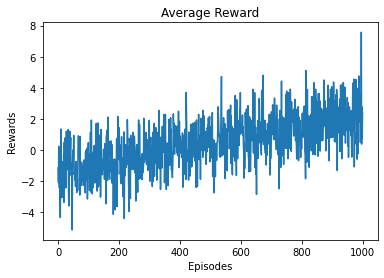

In [11]:
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.title('Average Reward')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Rewards')

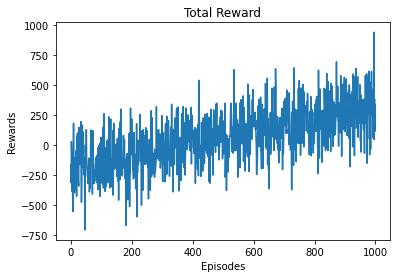

In [12]:
plt.plot(list(range(len(total_rewards))), total_rewards)
plt.title('Total Reward')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Epsilon')

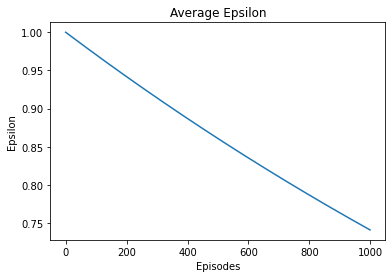

In [13]:
plt.plot(list(range(len(avg_epsilon))), avg_epsilon)
plt.title('Average Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')

### Tracking Convergence

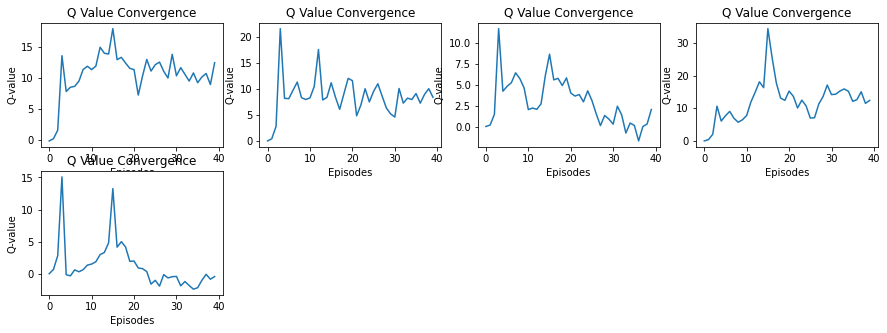

In [18]:
# Average Q Values should increase and then flatten out after a while

plt.figure(0, figsize=(15,5))
i=1
for state in states_to_track.keys():
    for action in states_to_track[state].keys():
        states_to_track[state][action]
        xaxis = np.asarray(range(len(states_to_track[state][action])))
        plt.subplot(2,4,i)
        plt.plot(xaxis,np.asarray(states_to_track[state][action]))
        plt.title("Q Value Convergence")
        plt.ylabel("Q-value")
        plt.xlabel("Episodes")
        i+=1

plt.show()

[[-0.14264359, 0.2128628, 1.5801395, 13.546493, 7.797157, 8.482838, 8.622178, 9.457542, 11.3375435, 11.852635, 11.316767, 11.877765, 14.907432, 13.941141, 13.818539, 17.898615, 12.907345, 13.283213, 12.367196, 11.518027, 11.31206, 7.2240868, 10.275028, 12.943535, 11.0845995, 12.099808, 12.522667, 11.036378, 9.965567, 13.769623, 10.318116, 11.62766, 10.55683, 9.47356, 10.777678, 9.2080965, 10.129455, 10.687794, 8.915624, 12.420691], [0.017027706, 0.44723892, 2.8192537, 21.608175, 8.208152, 8.138226, 9.763778, 11.334895, 8.332665, 7.9801226, 8.293489, 10.483598, 17.58971, 7.893191, 8.386384, 11.196569, 8.448028, 6.0939794, 9.0957365, 12.043018, 11.610866, 4.849314, 6.919037, 10.0503235, 7.5166984, 9.54826, 11.003467, 8.665437, 6.362512, 5.217141, 4.609808, 10.095041, 7.2834024, 8.247406, 7.9816327, 9.1295, 7.2889915, 8.94747, 10.057741, 8.407536], [0.04229451, 0.21550429, 1.489885, 11.694334, 4.242358, 4.82508, 5.2558775, 6.4326477, 5.7431226, 4.638341, 2.0570087, 2.2351468, 2.0842445, 2

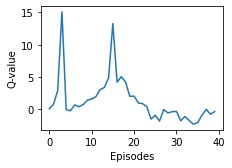

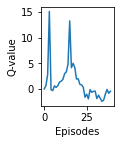

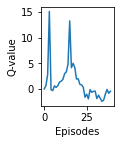

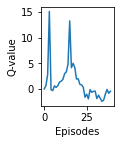

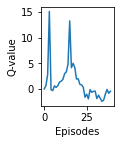

In [19]:
plt.figure(0, figsize=(15,5))
actions_list = []
for state in states_to_track.keys():
    for action in states_to_track[state].keys():
        actions_list.append(states_to_track[state][action])
        
print(actions_list)
xaxis = np.asarray(range(len(actions_list[0])))
plt.subplot(2,4,1)
plt.plot(xaxis,np.asarray(states_to_track[state][action]))
plt.ylabel("Q-value")
plt.xlabel("Episodes")
plt.show()

xaxis = np.asarray(range(len(actions_list[1])))
plt.subplot(2,4,2)
plt.plot(xaxis,np.asarray(states_to_track[state][action]))
plt.ylabel("Q-value")
plt.xlabel("Episodes")
plt.show()

xaxis = np.asarray(range(len(actions_list[2])))
plt.subplot(2,4,3)
plt.plot(xaxis,np.asarray(states_to_track[state][action]))
plt.ylabel("Q-value")
plt.xlabel("Episodes")
plt.show()

xaxis = np.asarray(range(len(actions_list[3])))
plt.subplot(2,4,4)
plt.plot(xaxis,np.asarray(states_to_track[state][action]))
plt.ylabel("Q-value")
plt.xlabel("Episodes")
plt.show()

xaxis = np.asarray(range(len(actions_list[4])))
plt.subplot(2,4,5)
plt.plot(xaxis,np.asarray(states_to_track[state][action]))
plt.ylabel("Q-value")
plt.xlabel("Episodes")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [20]:
epsilon_max = 1.0
epsilon_decay = 0.0003
epsilon_min = 0.00000001
episodes = 1000

time = np.arange(0,episodes)
epsilon = []
for i in range(0,episodes):
    epsilon.append(epsilon_min + (epsilon_max - epsilon_min) * np.exp(-epsilon_decay*i))

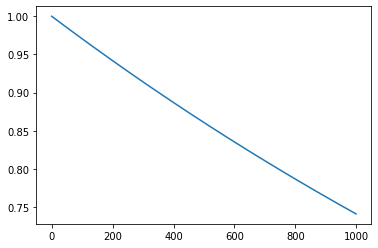

In [21]:
plt.plot(time, epsilon)
plt.show()